#Demo de TF-Agents para jugar al Blackjack (21) usando primero Q-Learning y luego una red DQN

 Basado inicialmente en los tutoriales de Tensor Flow: https://www.tensorflow.org/agents/tutorials/1_dqn_tutorial

In [1]:
#@title Instalar Paquete de TF-Agents
# usar esta versión para evitar errores
# recomendada en https://github.com/tensorflow/agents
!pip install tf-agents[reverb]
!git clone https://github.com/tensorflow/agents.git
!cd agents
#!git checkout v0.15.0  
print("TF-Agentes instalado.")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 624.4/624.4 KB 32.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.4/48.4 KB 680.4 kB/s eta 0:00:00
  Created wheel for gym: filename=gym-0.23.0-py3-none-any.whl size=697661 sha256=6bd0d86928450d1f449cf9b7071e7601d27b06c8e32a0fdb00e517d5fe34b7b6
  Stored in directory: /root/.cache/pip/wheels/96/b9/bb/994c1324b65e39dd1cd7b8ba92e5fb766dd77980929414a866
Successfully built gym
  Attempting uninstall: gym
    Found existing installation: gym 0.25.2
    Uninstalling 

In [2]:
#@title Cargar Librerías

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import abc
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import random
from random import randint
import pandas as pd


import reverb
from tf_agents.environments import py_environment
from tf_agents.environments import tf_py_environment
from tf_agents.environments import utils
from tf_agents.specs import array_spec
from tf_agents.policies import random_tf_policy
from tf_agents.trajectories import time_step as ts

from tf_agents.agents.dqn import dqn_agent
from tf_agents.agents import CategoricalDqnAgent
from tf_agents.networks import q_network, categorical_q_network
from tf_agents.utils import common

from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory

from tf_agents.networks import sequential
from tf_agents.specs import tensor_spec
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.drivers import py_driver
from tf_agents.policies import py_tf_eager_policy

tf.compat.v1.enable_v2_behavior()

print("Librerías cargadas.")
print("(nota: ignorar el error que tira por diferencias de versiones)")

RuntimeError: ignored

Librerías cargadas.
(nota: ignorar el error que tira por diferencias de versiones)


## Clases sobre el Problema a resolver

In [3]:
#@title Definir Entorno del Problema 

# Un entorno que represente el juego podría verse así:
##Acciones: Tenemos dos acciones. 
##             Acción 0: obtener una nueva carta 
##             Acción 1: terminar la ronda actual.
##Observaciones: Suma de las cartas de la ronda actual.
##Recompensa: El objetivo es acercarse lo más posible a 21 sin pasarse, 
##            por lo que podemos lograrlo usando la siguiente recompensa al final de la ronda: 
##            suma_de_tarjetas - 21 si suma_de_tarjetas <= 21, de lo contrario -21

posiblesAccionesDescrip = ["pide carta", "decide no pedir más cartas"]
posiblesEstadosDescrip = ['SUMA={:}'.format(x) for x in range(0, 33)]
posiblesCartas = ['-', 'As', '2', '3', '4', '5', '6', '7', '8', '9', '10', 'J', 'Q', 'K']
class CardGameEnv(py_environment.PyEnvironment):

  def __init__(self):
    self._action_spec = array_spec.BoundedArraySpec(
        shape=(), dtype=np.int32, minimum=0, maximum=1, name='action')
    self._observation_spec = array_spec.BoundedArraySpec(
        shape=(2,), dtype=np.int32, minimum=0, name='observation')
    self._state = 0
    self._episode_ended = False

  def action_spec(self):
    # devuelve la forma de las acciones
    return self._action_spec

  def observation_spec(self):
    # devuelve la forma de las observaciones   
    return self._observation_spec

  def _reset(self):
    # resetea el entorno
    self._state = 0
    self._episode_ended = False
    return ts.restart(np.array([self._state, 0], dtype=np.int32))

  def _step(self, action):
    # aplica una acción sobre el entorno
    
    if self._episode_ended:
      # si el entorno está finalizado, lo resetea
      return self.reset()

    # Aplica la acción
    if action == 1:
      # indica no seguir jugando
      self._episode_ended = True
      new_card = 0
    elif action == 0:
      # solicita una carta
      new_card = randint(1, 12)
      if new_card == 1:
        # el as puede valer 1 o 11
        if (self._state + 11) < 21:
          self._state = self._state + 11
        else:
          self._state = self._state + 1  
      elif new_card >= 10:
        # las figuras valen 10
        self._state = self._state + 10
      else:
        # el resto vale su valor
        self._state = self._state + new_card
      # se llega a un valor de 21, no se puede pedir más
      if self._state >= 21:
        self._episode_ended = True
    else:
      raise ValueError('La acción debe ser 0 o 1.')

    # finaliza 
    if self._episode_ended:
      # si finaliza
      # determina el reward (siempre se maximiza)
      # en este caso el máximo es 21!
      if self._state > 21:
        # se paso de 21, devuelve cantidad que se paso (negativo)
        reward = 21 - self._state 
      else:
        # no se paso de 21 (devuelve a donde llegó)
        reward = self._state 
      return ts.termination(np.array([self._state, new_card], dtype=np.int32), reward)
    else:
      # si no finaliza
      return ts.transition(
          np.array([self._state, new_card], dtype=np.int32), reward=0.0, discount=0.9)


print("Entorno del Problema definido.")

# Definir entornos de entrenamiento y evaluación
train_py_env = CardGameEnv()
eval_py_env = CardGameEnv()

# Definir wrapper para convertir en entornos TF
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# define política al azar independiente del Agente
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

print("Entornos de entrenamiento y prueba definidos. ")


# definir simulador para probar el entorno
def SimularEntorno(eval_env, policy, titulo, num_episodes=1, mostrarDetalleStep=False):
    if num_episodes <=0:
      num_episodes = 1    
    # inicializa acumulador auxiliar 
    cumulative_reward_total = 0.0    
    print("\n** ", titulo, "**")                   
    for i in range(num_episodes):
      if num_episodes>1:
        print("\n> Episodio ", i+1, ": ")
      # muesta estado inicial
      time_step = eval_env.reset()  
      ob = time_step.observation.numpy()[0]
      if mostrarDetalleStep:
        print(" Ini: estado", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")      
      else:
        print(" Ini: estado", posiblesEstadosDescrip[ob[0]])      
      j = 1
      while not time_step.is_last():
        # la política determina la acción a realizar
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        # recupera la observación y muestra el nuevo estado 
        ob = time_step.observation.numpy()[0]
        if ob[1] == 0:
          descAccion = posiblesAccionesDescrip[1]
        else:
          descAccion = posiblesAccionesDescrip[0] + " " + posiblesCartas[ob[1]]
        if mostrarDetalleStep:
          print(" #", j, ":", descAccion, "-> estado:", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")
        else:
          print(" #" + str(j) + ":", descAccion, "-> estado:", posiblesEstadosDescrip[ob[0]])
        j = j + 1
        
      # muestra estado final
      ob = time_step.observation.numpy()[0]
      r = time_step.reward.numpy()
      if mostrarDetalleStep:
        print(" Fin -> estado", posiblesEstadosDescrip[ob[0]], "[", time_step, "]")
      else:
        print(" Fin -> estado", posiblesEstadosDescrip[ob[0]])
      print(' Recompensa final = ', r[0])
      cumulative_reward_total += r[0]
    if num_episodes > 1:
      promedioEpisodios = round(cumulative_reward_total/num_episodes,3)
      print("\n= Recompensa Promedio Total: ", promedioEpisodios, "\n")
      return promedioEpisodios
    else:
      return cumulative_reward_total


# función auxiliar para comparar
def compararRtdosPolicy(cantidad_probar, eval_env, policy1, policy2, descPol1="Agente 1", descPol2="Agente 2"):
  prom1 = 0
  prom2 = 0
  for i in range(cantidad_probar):
    print("\n> Prueba ", i+1, ":")
    # Probar 1
    valor1 = SimularEntorno(eval_env, policy1, "Resultados de " + descPol1, False) 
    prom1 = prom1 + valor1
    # Probar 2
    valor2 = SimularEntorno(eval_env, policy2, "Resultados de " + descPol2, False) 
    prom2 = prom2 + valor2
    # Decide Ganador
    strMostrar = "\n--> " + descPol1 + " (%s) genera" % valor1
    if valor1 > valor2:
      strMostrar = strMostrar + " MEJOR "
    elif valor1 < valor2:
      strMostrar = strMostrar + " PEOR "
    else:
      strMostrar = strMostrar + " IGUAL "
    strMostrar = strMostrar + "resultado que " + descPol2 + " (%s)." % valor2
    print(strMostrar)
  # Decide Ganador General
  if cantidad_probar > 0:
    prom1 = prom1 / cantidad_probar
    prom2 = prom2 / cantidad_probar
    print("\n================================================================================================\n")
    strMostrar = " * En Promedio " + descPol1 + " (%s) genera" % prom1
    if prom1 > prom2:
      strMostrar = strMostrar + " MEJORES "
    elif prom1 < prom2:
      strMostrar = strMostrar + " PEORES "
    else:
      strMostrar = strMostrar + " IGUALES "
    strMostrar = strMostrar + "resultados que " + descPol2 + " (%s)." % prom2
    print(strMostrar)
    print("\n================================================================================================\n")


print("Simulador del entorno definido.")

# Probar el entorno definido con Política Aleatoria (opcional)
Probar_Entorno = True #@param {type:"boolean"}
MostarDetalleSteps = False #@param {type:"boolean"}

if Probar_Entorno:
  SimularEntorno(eval_env, random_policy, "Probando el entorno del problema al azar", 1, MostarDetalleSteps)


Entorno del Problema definido.
Entornos de entrenamiento y prueba definidos. 
Simulador del entorno definido.

**  Probando el entorno del problema al azar **
 Ini: estado SUMA=0
 #1: decide no pedir más cartas -> estado: SUMA=0
 Fin -> estado SUMA=0
 Recompensa final =  0.0


##Q-Learning

In [4]:
#@title Define clase auxiliar Policy para Q-Learning

## funciones auxiliares basadas en:
##  https://rubikscode.net/2019/06/24/introduction-to-q-learning-with-python-and-open-ai-gym/

from tf_agents.policies.fixed_policy import FixedPolicy
from tf_agents.trajectories import policy_step
from tf_agents.utils import nest_utils
from tf_agents.specs import tensor_spec
from tf_agents.typing import types
from typing import Optional, Text

## funciones auxiliares para manejar TS->Obs
## (se puede definir otras si es necesario)

# devuelve el primer valor de OBS 
# como número de estado
def obtenerEstadoDeObs(obs):  
  return obs[0]

# devuelve valor unico en base a vector OBS 
# para determinar fila de estado
def generarNroEstadoVector(obs):
  ntarget = np.array(obs).flatten()
  valorTotal = 0        
  for i in range(1, len(ntarget)):
    if ntarget[i] == -1:
      valorTotal = valorTotal + 2**i    
    elif ntarget[i] == 1:
      valorTotal = valorTotal + 3**i      
  return valorTotal

# devuelve la cantidad de estados máxima
# que se pueden generar usando un ejemplo 
# del vector de OBS 
def calcMaxNroEstadoVector(ejemploObs):
  ntarget = np.array(ejemploObs).flatten()  
  cant = len(ntarget)
  return ( 3**cant + 2**cant + 1 )


# Clase para Q-Learning
# (se hereda de FixedPolicy porque es una simple para tener como base)
class QL_TF_Policy(FixedPolicy):
    
  def __init__(self,
               posiblesEstadosList, 
               posiblesAccionesList,
               time_step_spec: ts.TimeStep,            
               action_spec: types.NestedTensorSpec,                              
               funcDevuelveNroEstado = obtenerEstadoDeObs,   
               policy_info: types.NestedTensorSpec = (),
               info_spec: types.NestedTensorSpec = (),
               name: Optional[Text] = None):    
    
      # llama al padre
      super(FixedPolicy, self).__init__(time_step_spec, action_spec, clip=False,
                                      info_spec=info_spec,
                                      name=name,
                                      emit_log_probability=False)             
      # guarda valores auxiliares
      self._policy_info = policy_info
      self._time_step_spec = tensor_spec.from_spec(time_step_spec)
      self._action_spec = tensor_spec.from_spec(action_spec)   
      self._funcDevuelveNroEstado = funcDevuelveNroEstado
      # inicializa parametros de matriz
      if (posiblesEstadosList is None) or (len(posiblesEstadosList)<2):
       raise ValueError('No se ha definida la lista de posibles estdos!' )
      self._posiblesEstadosList = posiblesEstadosList
      self._cantEstados = len(posiblesEstadosList)
      if (posiblesAccionesList is None) or (len(posiblesAccionesList)<2):
       raise ValueError('No se ha definida la lista de posibles acciones!' )
      self._posiblesAccionesList = posiblesAccionesList
      self._cantAcciones = len(posiblesAccionesList)
      self.ResetQ()
  
  # funcion auxiliar para inicializar la matriz
  def ResetQ(self):     
      self._Qtable = np.zeros([self._cantEstados, self._cantAcciones])
      self._QtableEntrenada = False 

  # función auxiliar de entrenamiento
  def TrainQ(self, env, train_policy, alpha = 0.1, gamma = 0.6, epsilon = 0.1, cant_ciclos_entrenamiento = 100000, log_cada_ciclos = 1000, mostrarDetalleAcciones=False):
      ##print(self._Qtable.shape)
      ##print(self._usarOBSVector)
      # ejecuta el entrenamiento
      for step in range(1, cant_ciclos_entrenamiento+1):
          # Resetea el enviroment
          time_step = env.reset()  
          ob = time_step.observation.numpy()[0]
          state = self._funcDevuelveNroEstado(ob)
          secuenciaAcciones = ""
          j = 1
          # Simula      
          while not time_step.is_last():
              # Considera lo aprendido o toma al azar depende de azar y epsilon
              if random.uniform(0, 1) < epsilon:
                  # toma de Matriz-Q
                  accionAplicar = np.argmax( self._Qtable[state] )              
              else:
                  # toma al azar
                  action_step = train_policy.action( time_step ) 
                  accionAplicar = action_step.action.numpy()[0]
              if j > 1:
                secuenciaAcciones = secuenciaAcciones + " + "
              secuenciaAcciones = secuenciaAcciones + self._posiblesAccionesList[ accionAplicar ]	
              j = j + 1
              # Aplica la Accion  
              time_step = env.step( accionAplicar )
              ob = time_step.observation.numpy()[0]
              next_state = self._funcDevuelveNroEstado(ob)
              r = time_step.reward.numpy()[0] 
              # Recalcula Q
              q_value = self._Qtable[state, accionAplicar]
              max_value = np.max(self._Qtable[next_state])
              new_q_value = (1 - alpha) * q_value + alpha * (r + gamma * max_value)                       
              # Actualiza Matriz-Q
              self._Qtable[state, accionAplicar] = new_q_value
              state = next_state        
          # muestra estado
          if log_cada_ciclos > 0:
            if (step == 1) or (step % log_cada_ciclos == 0):
              if mostrarDetalleAcciones:
                print('step = {0}: Recompensa = {1} - Acciones({2}) = {3} '.format(step, r, (j-1), secuenciaAcciones))  
              else:
                print('step = {0}: Recompensa = {1} - Acciones({2}) '.format(step, r, (j-1)))  
      # Devuelve Matriz-Q
      self._QtableEntrenada = True
      return self._Qtable   

  # obtiene Q-Table como DataFrame
  def getQ_DF(self):
        cm = self._Qtable 
        cmtx = pd.DataFrame(
            cm, 
            index=self._posiblesEstadosList, 
            columns=self._posiblesAccionesList
          )
        return cmtx

  # graba Q-Table como CSV
  def saveQ(self, fileName):
        # obtiene data frame de matriz Q
        df = self.getQ_DF()
        # graba matriz Q como CSV
        df.to_csv(fileName, index=True)
        return 

  # recupera Q-Table de  CSV
  def loadQ(self, fileName):
        # lee matriz Q de CSV
        df = pd.read_csv(fileName)         
        # carga elementos en memoria
          # saca nombre de estados
        self._posiblesEstadosList = list(df.pop(df.columns[0]))  
          # acciones
        self._posiblesAccionesList = list(df.columns.tolist())
          # borra el primer elemento de titulo
        ##self._posiblesAccionesList = np.delete(self._posiblesAccionesList, 0, axis=0)      
         # matriz Q
        self._Qtable = list(df.to_numpy())
        # re-inicializa las cantidades
        self._cantEstados = len(self._posiblesEstadosList)
        self._cantAcciones = len(self._posiblesAccionesList)
        self._QtableEntrenada = True
        # muestra resultados
        self.MostrarQ("Matriz-Q recuperada:")
        return 

  # función auxiliar para mostrar matri Q
  def MostrarQ(self, titulo="Matriz-Q entrenada:"):
        # muestra Q table
        cmtx = self.getQ_DF()
        print('\n ' + titulo + ' ')        
        # agrega para poder mostrar la matrix de confusión completa
        pd.options.display.max_rows = 100
        pd.options.display.max_columns = 100
        print(cmtx)
        print("\n")
        return 

  # devuelve la accion que se debe aplicar usando la matrix Q entrenada
  def _action(self, time_step, policy_state, seed):    
      # determina la accion a realizar
      # obtiene estado actual
      ob = time_step.observation.numpy()[0]
      state = self._funcDevuelveNroEstado(ob)
      # toma de Matriz-Q      
      accionAplicar = np.argmax( self._Qtable[state] )
      # formatea el valor a devolver usando la action_spec y time_step_spec
      def convert(action, spec):
        return tf.convert_to_tensor(value=action, dtype=spec.dtype)
      self._action_value = tf.nest.map_structure(convert, accionAplicar,
                                                  self._action_spec)
      outer_shape = nest_utils.get_outer_shape(time_step, self._time_step_spec)
      action = tf.nest.map_structure(lambda t: common.replicate(t, outer_shape),
                                   self._action_value)
      # devuelve la accion
      return policy_step.PolicyStep(action, policy_state, self._policy_info)


print("Clase QL_TF_Policy creada.")

Clase QL_TF_Policy creada.


In [5]:
#@title Entrenar con algoritmo Q-Learning

# parámetros
entrenar_QL = True #@param {type:"boolean"}
alpha = 0.1 #@param {type:"number"}
gamma = 0.8 #@param {type:"number"}
epsilon = 0.4 #@param {type:"number"}
cant_ciclos_entrenamiento_finalizar = 5000 #@param {type:"integer"}
mostar_recompensa_cada = 500  #@param {type:"integer"}
if alpha <= 0.0:
   alpha = 0.001
if gamma <= 0.0:
    gamma = 0.001
if epsilon <= 0.0:
   epsilon = 0.001    
if cant_ciclos_entrenamiento_finalizar <= 10:
   cant_ciclos_entrenamiento_finalizar = 10    
if mostar_recompensa_cada < 1:
  mostar_recompensa_cada = 1

# instancia política de Q Learning
ql_policy = QL_TF_Policy(posiblesEstadosList = posiblesEstadosDescrip,
                         posiblesAccionesList = posiblesAccionesDescrip,                         
                         time_step_spec = train_env.time_step_spec(),
                         action_spec = train_env.action_spec(),
                         funcDevuelveNroEstado = obtenerEstadoDeObs
                         )

if entrenar_QL:
  # hace el entrenamiento
  print("** Comienza el Entrenamiento:\n")
  ql_policy.TrainQ(env = train_env, 
                   train_policy = random_policy, 
                   alpha = alpha, gamma = gamma, epsilon = epsilon, 
                   cant_ciclos_entrenamiento = cant_ciclos_entrenamiento_finalizar, 
                   log_cada_ciclos = mostar_recompensa_cada,
                   mostrarDetalleAcciones = True)
  print("\n** Entrenamiento Finalizado **")
  # muestra matriz
  ql_policy.MostrarQ()
else:
  print("No se ejecuta entrenamiento de Agente Q-Learning.")  

** Comienza el Entrenamiento:

step = 1: Recompensa = -2.0 - Acciones(4) = pide carta + pide carta + pide carta + pide carta 
step = 500: Recompensa = 10.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 1000: Recompensa = 18.0 - Acciones(4) = pide carta + pide carta + pide carta + decide no pedir más cartas 
step = 1500: Recompensa = 10.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 2000: Recompensa = 2.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 2500: Recompensa = 10.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 3000: Recompensa = 0.0 - Acciones(1) = decide no pedir más cartas 
step = 3500: Recompensa = 0.0 - Acciones(1) = decide no pedir más cartas 
step = 4000: Recompensa = 11.0 - Acciones(3) = pide carta + pide carta + decide no pedir más cartas 
step = 4500: Recompensa = 9.0 - Acciones(2) = pide carta + decide no pedir más cartas 
step = 5000: Recompensa = 10.0 - Acciones(2) = pide carta + decide no pedi

In [6]:
#@title Probar Q-Learning Entrenado contra el Azar
cantidad_probar = 10 # @param {type:"integer"}

if ql_policy._QtableEntrenada:
  compararRtdosPolicy(cantidad_probar, eval_env, ql_policy, random_policy, "Agente Q-Learning entrenado", "el Azar")



> Prueba  1 :

**  Resultados de Agente Q-Learning entrenado **
 Ini: estado SUMA=0
 #1: pide carta 2 -> estado: SUMA=2
 #2: pide carta J -> estado: SUMA=12
 #3: decide no pedir más cartas -> estado: SUMA=12
 Fin -> estado SUMA=12
 Recompensa final =  12.0

**  Resultados de el Azar **
 Ini: estado SUMA=0
 #1: pide carta 2 -> estado: SUMA=2
 #2: pide carta Q -> estado: SUMA=12
 #3: pide carta J -> estado: SUMA=22
 Fin -> estado SUMA=22
 Recompensa final =  -1.0

--> Agente Q-Learning entrenado (12.0) genera MEJOR resultado que el Azar (-1.0).

> Prueba  2 :

**  Resultados de Agente Q-Learning entrenado **
 Ini: estado SUMA=0
 #1: pide carta J -> estado: SUMA=10
 #2: pide carta Q -> estado: SUMA=20
 #3: decide no pedir más cartas -> estado: SUMA=20
 Fin -> estado SUMA=20
 Recompensa final =  20.0

**  Resultados de el Azar **
 Ini: estado SUMA=0
 #1: decide no pedir más cartas -> estado: SUMA=0
 Fin -> estado SUMA=0
 Recompensa final =  0.0

--> Agente Q-Learning entrenado (20.0) gene

##DQN

In [7]:
#@title Definir el Agente tipo DQN
entrenar_DQN = True # @param {type:"boolean"}
DQNpolicy = None

if entrenar_DQN:
  # agente categorical oculto por ahora (problemas en librería)
  tipo_agente = "DQN" #param ["DQN", "DQN Categorico (C51)"]
  learning_rate = 1e-3  # @param {type:"number"}
  cant_neuronas_ocultas = "100, 50" # @param {type:"string"}
  DQNCat_num_atoms = 51  #param {type:"integer"}

  # controla cantidad de atoms para DQN Cat
  if DQNCat_num_atoms <= 1:
    DQNCat_num_atoms = 51

  #define las capas convolutional
  CNN_preprocessing_layers = None

  # Define cantidad de neuronas ocultas para RNA-Q
  hidden_layers = []
  for val in cant_neuronas_ocultas.split(','):
    if  int(val) < 1:
      hidden_layers.append( 10 )
    else:
      hidden_layers.append( int(val) )
  fc_layer_params = tuple(hidden_layers, )
  #print(fc_layer_params)

  if tipo_agente=="DQN":

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    train_step_counter = tf.Variable(0)

    # Define RNA-Q
    q_net = q_network.QNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        fc_layer_params=fc_layer_params)

    # Define el agente de tipo Q
    ag = dqn_agent.DqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        q_network=q_net,
        optimizer=optimizer,
        td_errors_loss_fn=common.element_wise_squared_loss,
        train_step_counter=train_step_counter)

    ag.initialize()

    print("Agente DQN inicializado. ")

  elif tipo_agente == "DQN Categorico (C51)":
    
    # Define RNA-Q Categórico
    categorical_q_net = categorical_q_network.CategoricalQNetwork(
        train_env.observation_spec(),
        train_env.action_spec(),
        num_atoms=DQNCat_num_atoms,
        fc_layer_params=fc_layer_params)

    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

    train_step_counter = tf.compat.v2.Variable(0)
    
    # parámetros especificos (por defecto)
    n_step_update = 2
    gamma = 0.99

    # Define el agente de tipo Q Categórico
    ag = CategoricalDqnAgent(
        train_env.time_step_spec(),
        train_env.action_spec(),
        categorical_q_network=categorical_q_net,
        optimizer=optimizer,
        n_step_update=n_step_update,
        td_errors_loss_fn=common.element_wise_squared_loss,
        gamma=gamma,
        train_step_counter=train_step_counter)
    
    ag.initialize()
    
    print("Agente DQN Categorico (C51) inicializado. ")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  

Agente DQN inicializado. 


In [8]:
#@title Métricas para evaluación y Preparar datos para Entrenamiento del Agente DQN

if entrenar_DQN:

  # parámetros
  initial_collect_steps = 100  # @param {type:"integer"} 
  collect_steps_per_iteration = 10# @param {type:"integer"}
  replay_buffer_max_length = 100000  # @param {type:"integer"}
  batch_size = 64  # @param {type:"integer"}
  num_eval_episodes = 10  # @param {type:"integer"}

  # Definir Métricas para evaluación para Agente DQN
    
  #eval_policy = ag.policy
  #collect_policy = ag.collect_policy
  #time_step = train_env.reset()

  # Se usa el promedio de la recompensa (la más común)
  # See also the metrics module for standard implementations of different metrics.
  # https://github.com/tensorflow/agents/tree/master/tf_agents/metrics

  def compute_avg_return(environment, policy, num_episodes=10):
    if num_episodes == 0:
        return 0.0 
    total_return = 0.0
    for _ in range(num_episodes):

      time_step = environment.reset()
      episode_return = 0.0

      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = environment.step(action_step.action)
        episode_return += time_step.reward
      total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]

  ##compute_avg_return(eval_env, random_policy, num_eval_episodes)

  # Define 'Replay Buffer' para que el agente recuerde las observaciones realizadas

  table_name = 'uniform_table'
  replay_buffer_signature = tensor_spec.from_spec(
        ag.collect_data_spec)
  replay_buffer_signature = tensor_spec.add_outer_dim(
      replay_buffer_signature)

  table = reverb.Table(
      table_name,
      max_size=replay_buffer_max_length,
      sampler=reverb.selectors.Uniform(),
      remover=reverb.selectors.Fifo(),
      rate_limiter=reverb.rate_limiters.MinSize(1),
      signature=replay_buffer_signature)

  reverb_server = reverb.Server([table])

  replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
      ag.collect_data_spec,
      table_name=table_name,
      sequence_length=2,
      local_server=reverb_server)

  rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)      

  print("\nDatos recolectados.")

  # Dataset generates trajectories with shape [Bx2x...]
  dataset = replay_buffer.as_dataset(
      num_parallel_calls=3,
      sample_batch_size=batch_size,
      num_steps=2).prefetch(3)
  iterator = iter(dataset)
  
  print("\nDataset creado para datos recolectadso.")

else:
  print("No se ejecuta entrenamiento de Agente DQN.")  


Datos recolectados.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089



Dataset creado para datos recolectadso.


In [9]:
#@title Entrenar al Agente DQN

if entrenar_DQN:

  cant_ciclos_entrenamiento_finalizar = 20000# @param {type:"integer"}
  log_cada_ciclos = 200  # @param {type:"integer"}
  mostar_recompensa_cada = 500  # @param {type:"integer"}
  cant_episodios_evaluacion =  10# @param {type:"integer"}
  minima_recompensa_promedio_finalizar = 19.0 # @param {type:"number"}
  
  # (Optional) Optimize by wrapping some of the code in a graph using TF function.
  ag.train = common.function(ag.train)

  # Reset the train step.
  ag.train_step_counter.assign(0)

  # Evaluate the agent's policy once before training.  
  avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
  ar_cicloL = []
  ar_cicloR = []
  ar_returns = []
  ar_loss = []

  # Reset the environment.
  time_step = train_py_env.reset()

  # Create a driver to collect experience.
  collect_driver = py_driver.PyDriver(
      train_py_env,
      py_tf_eager_policy.PyTFEagerPolicy(
        ag.collect_policy, use_tf_function=True),
      [rb_observer],
      max_steps=collect_steps_per_iteration)

  print("\n** Comienza el Entrenamiento **\n")
  for _ in range(cant_ciclos_entrenamiento_finalizar):

    # Collect a few steps and save to the replay buffer.
    time_step, _ = collect_driver.run(time_step)

    # Sample a batch of data from the buffer and update the agent's network.
    experience, unused_info = next(iterator)
    train_loss = ag.train(experience).loss

    step = ag.train_step_counter.numpy()    

    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % log_cada_ciclos == 0):
      print('step = {0}: loss = {1:.3f}'.format(step, train_loss))    
      ar_cicloL.append( step )
      ar_loss.append( train_loss )
    
    if (step == 1) or (step == cant_ciclos_entrenamiento_finalizar) or (step % mostar_recompensa_cada == 0):
      avg_return = compute_avg_return(eval_env, ag.policy, cant_episodios_evaluacion)
      ar_cicloR.append( step )
      ar_returns.append( avg_return )
      print('step = {0}: Promedio Recompensa = {1:.1f}'.format(step, avg_return))

      if (avg_return >= minima_recompensa_promedio_finalizar):
        print('** Finaliza en step {0} por buen valor de recompensa promedio: {1:.1f}'.format(step, avg_return)) 
        break

  DQNpolicy = ag.policy
  print("\n** Entrenamiento Finalizado **\n")
else:
  print("No se ejecuta entrenamiento de Agente DQN.")  


** Comienza el Entrenamiento **



Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


step = 1: loss = 0.688
step = 1: Promedio Recompensa = 0.0
step = 200: loss = 11.873
step = 400: loss = 11.353
step = 500: Promedio Recompensa = 12.4
step = 600: loss = 12.758
step = 800: loss = 4.533
step = 1000: loss = 3.183
step = 1000: Promedio Recompensa = 13.2
step = 1200: loss = 5.203
step = 1400: loss = 4.597
step = 1500: Promedio Recompensa = 15.8
step = 1600: loss = 9.167
step = 1800: loss = 9.128
step = 2000: loss = 4.839
step = 2000: Promedio Recompensa = 12.8
step = 2200: loss = 8.361
step = 2400: loss = 9.595
step = 2500: Promedio Recompensa = 16.0
step = 2600: loss = 5.691
step = 2800: loss = 2.946
step = 3000: loss = 4.227
step = 3000: Promedio Recompensa = 14.3
step = 3200: loss = 4.892
step = 3400: loss = 7.401
step = 3500: Promedio Recompensa = 14.8
step = 3600: loss = 4.719
step = 3800: loss = 2.740
step = 4000: loss = 2.366
step = 4000: Promedio Recompensa = 15.8
step = 4200: loss = 5.218
step = 4400: loss = 4.916
step = 4500: Promedio Recompensa = 15.4
step = 4600

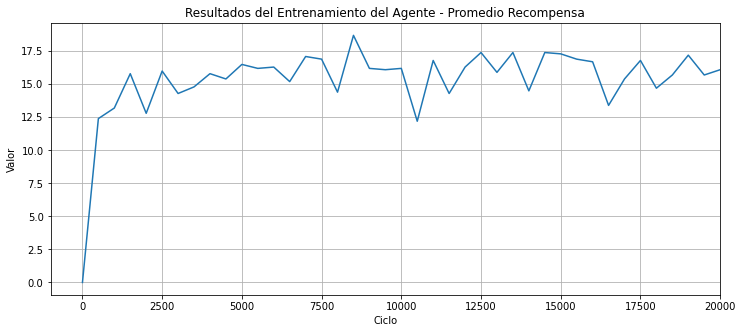

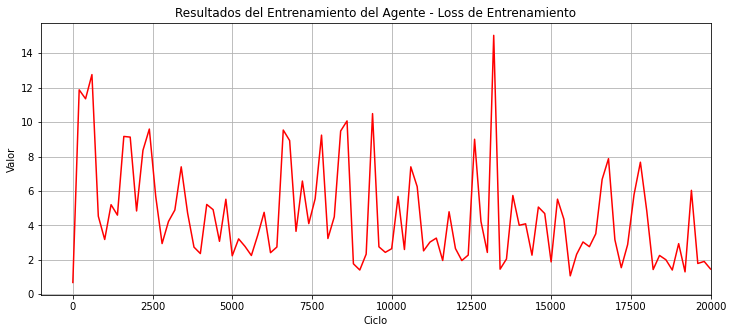

In [10]:
#@title Mostrar Gráficos del Entrenamiento del Agente DQN

if entrenar_DQN:

  plt.figure(figsize=(12,5)) 
  plt.plot( ar_cicloR, ar_returns)
  plt.title("Resultados del Entrenamiento del Agente - Promedio Recompensa")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloR))   
  plt.grid(True)
  plt.show()

  plt.figure(figsize=(12,5)) 
  plt.plot( ar_cicloL, ar_loss, color="red" )
  plt.title("Resultados del Entrenamiento del Agente - Loss de Entrenamiento")
  #plt.legend(['Promedio Recompensa', 'Loss de Entrenamiento'], loc='upper right')
  plt.ylabel('Valor')
  plt.xlabel('Ciclo')
  plt.xlim(right=max(ar_cicloL))   
  plt.grid(True)
  plt.show()


In [11]:
#@title Probar el Agente DQN Entrenado contra el Azar
cantidad_probar = 10 # @param {type:"integer"}

if DQNpolicy is not None:
  compararRtdosPolicy(cantidad_probar, eval_env, DQNpolicy, random_policy, "Agente DQN entrenado", "el Azar")



> Prueba  1 :

**  Resultados de Agente DQN entrenado **
 Ini: estado SUMA=0
 #1: pide carta 4 -> estado: SUMA=4
 #2: pide carta 7 -> estado: SUMA=11
 #3: pide carta 9 -> estado: SUMA=20
 #4: decide no pedir más cartas -> estado: SUMA=20
 Fin -> estado SUMA=20
 Recompensa final =  20.0

**  Resultados de el Azar **
 Ini: estado SUMA=0
 #1: pide carta 8 -> estado: SUMA=8
 #2: pide carta 4 -> estado: SUMA=12
 #3: decide no pedir más cartas -> estado: SUMA=12
 Fin -> estado SUMA=12
 Recompensa final =  12.0

--> Agente DQN entrenado (20.0) genera MEJOR resultado que el Azar (12.0).

> Prueba  2 :

**  Resultados de Agente DQN entrenado **
 Ini: estado SUMA=0
 #1: pide carta J -> estado: SUMA=10
 #2: pide carta J -> estado: SUMA=20
 #3: decide no pedir más cartas -> estado: SUMA=20
 Fin -> estado SUMA=20
 Recompensa final =  20.0

**  Resultados de el Azar **
 Ini: estado SUMA=0
 #1: pide carta As -> estado: SUMA=11
 #2: decide no pedir más cartas -> estado: SUMA=11
 Fin -> estado SUMA=11

## Comparar Q-Learning y DQN

In [15]:



#@title Cargar o Guardar los Agentes Q-Learning y DQN entrenados

# parámetros
directorio_modelo = '/content/gdrive/MyDrive/IA/demoRL/Modelos' #@param {type:"string"}
nombre_modelo_grabar = "policy-Blackjack" #@param {type:"string"}
accion_realizar = "-" #@param ["-", "Cargar Modelo", "Grabar Modelo"]

if accion_realizar != "-":
  import os
  from google.colab import drive
  from tf_agents.policies import TFPolicy, policy_saver
  # determina lugar donde se guarda el modelo
  policy_dir = os.path.join(directorio_modelo, nombre_modelo_grabar)
  qlCSV = policy_dir + "/QM-QLearning.csv"
  # Montar Drive
  drive.mount('/content/gdrive')
if accion_realizar == "Grabar Modelo":
  if (DQNpolicy is not None) and isinstance(DQNpolicy, TFPolicy):
    # guarda la politica del agente DQN entrenado
    tf_policy_saver = policy_saver.PolicySaver(DQNpolicy)
    tf_policy_saver.save(policy_dir)
    print("\nPolítica DQN guardada en ", policy_dir)
  if ql_policy is not None:
    if not os.path.exists(policy_dir):
         os.makedirs(policy_dir)
    ql_policy.saveQ(qlCSV)
    print("\nPolítica Q-Learning guardada en ", qlCSV)
elif accion_realizar == "Cargar Modelo":
  # carga la política del modelo
  DQNpolicy = tf.compat.v2.saved_model.load(policy_dir)
  print("\nPolítica DQN recuperada de ", policy_dir)
  ql_policy.loadQ(qlCSV)
  print("\nPolítica Q-Learning recuperada de ", qlCSV)


Mounted at /content/gdrive


/usr/local/lib/python3.9/dist-packages/tensorflow/python/saved_model/nested_structure_coder.py:521: UserWarning: Encoding a StructuredValue with type tfp.distributions.Deterministic_ACTTypeSpec; loading this StructuredValue will require that this type be imported and registered.
  warnings.warn("Encoding a StructuredValue with type %s; loading this "



Política DQN guardada en  /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-Blackjack

Política Q-Learning guardada en  /content/gdrive/MyDrive/IA/demoRL/Modelos/policy-Blackjack/QM-QLearning.csv


In [13]:
#@title Probar Q-Learning Entrenado contra Agente DQN Entrenado
cantidad_probar = 10 # @param {type:"integer"}

if DQNpolicy is not None and ql_policy._QtableEntrenada:
  compararRtdosPolicy(cantidad_probar, eval_env, DQNpolicy, ql_policy, "Agente DQN", "Agente Q-Learning")



> Prueba  1 :

**  Resultados de Agente DQN **
 Ini: estado SUMA=0
 #1: pide carta J -> estado: SUMA=10
 #2: pide carta J -> estado: SUMA=20
 #3: decide no pedir más cartas -> estado: SUMA=20
 Fin -> estado SUMA=20
 Recompensa final =  20.0

**  Resultados de Agente Q-Learning **
 Ini: estado SUMA=0
 #1: pide carta 4 -> estado: SUMA=4
 #2: pide carta 7 -> estado: SUMA=11
 #3: decide no pedir más cartas -> estado: SUMA=11
 Fin -> estado SUMA=11
 Recompensa final =  11.0

--> Agente DQN (20.0) genera MEJOR resultado que Agente Q-Learning (11.0).

> Prueba  2 :

**  Resultados de Agente DQN **
 Ini: estado SUMA=0
 #1: pide carta As -> estado: SUMA=11
 #2: pide carta 2 -> estado: SUMA=13
 #3: decide no pedir más cartas -> estado: SUMA=13
 Fin -> estado SUMA=13
 Recompensa final =  13.0

**  Resultados de Agente Q-Learning **
 Ini: estado SUMA=0
 #1: pide carta 2 -> estado: SUMA=2
 #2: pide carta 4 -> estado: SUMA=6
 #3: pide carta 7 -> estado: SUMA=13
 #4: decide no pedir más cartas -> es

In [14]:
#@title Probar Agentes entrenados contra Usuario Humano 
#@markdown (notar que agentes no conocen las cartas que salieron al otro)
import ipywidgets as widgets
from IPython.display import display, clear_output

def resetear():
  global agentesDescrip, envAgentes, nroPasoAgentes, TSAgentes
  # Inicializar variables
  envAgentes = []
  nroPasoAgentes = []
  TSAgentes = []
  # Crea los entornos e inicializa variables
  for i in range(len(agentesDescrip)):
    env = tf_py_environment.TFPyEnvironment( CardGameEnv() )
    ts = env.reset()  
    #ob = time_step.observation.numpy()[0]    
    envAgentes.append( env )
    nroPasoAgentes.append( 1 )
    TSAgentes.append( ts )

def jugar(prefijoJugador, nombreJugador, env, paso, action):
  if paso < 0:
    # no se hace porque ya termino la partida
    return paso
  else:
    # aplica la acción
    time_step = env.step(action)
    # recupera la observación y muestra el nuevo estado 
    ob = time_step.observation.numpy()[0]
    if ob[1] == 0:
      descAccion = posiblesAccionesDescrip[1]
    else:
      descAccion =posiblesAccionesDescrip[0] + " " + posiblesCartas[ ob[1] ]
    print(prefijoJugador, "Juega", nombreJugador, "#" + str(paso) + ":", descAccion, "->", posiblesEstadosDescrip[ob[0]] )
    # ve si termino o sigue
    if time_step.is_last():
      paso = -1
    else:
      paso = paso + 1
    return paso, time_step

def jugarAgentes():
    global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes
    algunoPuedeSeguirJugando = False
    # inicia jugando primero a los agentes
    for i in range(len(agentesPolicy)):
      # no es humano
      if i != idPosHumano:
        # puede seguir jugando
        if nroPasoAgentes[i] >= 0:
          aux_action_step  = agentesPolicy[i].action( TSAgentes[i] )
          auxPaso, auxTS = jugar("*", agentesDescrip[i], envAgentes[i], nroPasoAgentes[i], aux_action_step.action)
          nroPasoAgentes[i] = auxPaso
          TSAgentes[i] = auxTS
          algunoPuedeSeguirJugando = algunoPuedeSeguirJugando or (auxPaso >= 0)
    return algunoPuedeSeguirJugando

# define funciones para los botones
def on_buttonR_clicked(b):
  global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes
  # se toca botón para reiniciar la partida
  with output:
    clear_output()
    print("\n> Nueva Partida:\n")
    # resetea ambientes
    resetear()
    # inicia jugando primero a los agentes
    jugarAgentes()
    # fuerza que le de la primera carta al humano
    on_button0_clicked(button0)
  # muestra botones
  display(button0, button1, buttonR, output)

def on_button0_clicked(b):
  global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes
  # se toca botón de pedir nueva carta
  with output:
    # juega humano
    if nroPasoAgentes[idPosHumano] >= 0:
      auxPaso, auxTS = jugar("+", agentesDescrip[idPosHumano], envAgentes[idPosHumano], nroPasoAgentes[idPosHumano], np.array(0, dtype=np.int32))
      nroPasoAgentes[idPosHumano] = auxPaso
      TSAgentes[idPosHumano] = auxTS
    print(" ")
    # juega agentes 
    puedenAGSeguir = True
    while puedenAGSeguir:
      puedenAGSeguir = jugarAgentes()
      if nroPasoAgentes[idPosHumano] >= 0:
        # si el humano no terminó, lo hace jugar una vez solamente
        break
    # si todos finalizaron, muestra el estado final
    if not(puedenAGSeguir) and (nroPasoAgentes[idPosHumano] < 0):
      mostrarEstadoFinal()

def on_button1_clicked(b):
  global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes
  # se toca botón de finalizar partida (plantarse)
  with output:
    # juega humano
    if nroPasoAgentes[idPosHumano] >= 0:
      auxPaso, auxTS = jugar("+", agentesDescrip[idPosHumano], envAgentes[idPosHumano], nroPasoAgentes[idPosHumano], np.array(1, dtype=np.int32))
      nroPasoAgentes[idPosHumano] = auxPaso
      TSAgentes[idPosHumano] = auxTS
    print(" ")
    # juega agentes hasta que terminen
    puedenAGSeguir = True
    while puedenAGSeguir:
      puedenAGSeguir = jugarAgentes()
    # muesta el estado final
    mostrarEstadoFinal()
    print("\n")

def mostrarEstadoFinal():
    global agentesDescrip, agentesPolicy, envAgentes, nroPasoAgentes, TSAgentes        
    # muestra estado final
    print("\n> Resultados: ")
    rewL = []
    for i in range(len(agentesDescrip)):
      r = int( TSAgentes[i].reward.numpy()[0] )
      rewL.append( r )
      resul = "%s" % r
      if (r > 21) or (r < 0):
        resul = resul + "!"
      print("\t " + agentesDescrip[i] + ": " + resul)
    # determina mejor resultado
    mejorPuntaje =  rewL[ np.argmax(rewL) ]
    cantGana = 0
    quienesGana = ""
    for i in range(len(rewL)):
        if mejorPuntaje == rewL[i]:
          cantGana = cantGana + 1
          if cantGana > 1:
            quienesGana = quienesGana + " & "
          quienesGana = quienesGana + agentesDescrip[i]
    if cantGana > 1:
      quienesGana = "GANAN: " + quienesGana
    else:
      quienesGana = "GANA: " + quienesGana
    print("\t = " + quienesGana)  
    print("\n")
    return


# inicializa variables auxiliares
idPosHumano = 2
agentesDescrip = []
agentesPolicy = []
# ql
if ql_policy._QtableEntrenada:
  agentesDescrip.append( "Agente QL" )
  agentesPolicy.append( ql_policy )
# dqn
if DQNpolicy is not None:
  agentesDescrip.append( "Agente DQN" )
  agentesPolicy.append( DQNpolicy )
# humano
agentesDescrip.append( "Humano" )
agentesPolicy.append( None )
resetear()

# define botones
button0 = widgets.Button(description="Dame Otra Carta")
button1 = widgets.Button(description="Plantarse")
buttonR = widgets.Button(description="Reiniciar Partida")
output = widgets.Output()
buttonR.on_click(on_buttonR_clicked)
button1.on_click(on_button1_clicked)
button0.on_click(on_button0_clicked)    

# comienza a jugar
on_buttonR_clicked(buttonR)




> Nueva Partida:

* Juega Agente QL #1: pide carta 7 -> SUMA=7
* Juega Agente DQN #1: pide carta 10 -> SUMA=10
+ Juega Humano #1: pide carta 10 -> SUMA=10
 
* Juega Agente QL #2: pide carta 10 -> SUMA=17
* Juega Agente DQN #2: pide carta Q -> SUMA=20


Button(description='Dame Otra Carta', style=ButtonStyle())

Button(description='Plantarse', style=ButtonStyle())

Button(description='Reiniciar Partida', style=ButtonStyle())

Output()

+ Juega Humano #2: pide carta As -> SUMA=11
 
* Juega Agente QL #3: decide no pedir más cartas -> SUMA=17
* Juega Agente DQN #3: decide no pedir más cartas -> SUMA=20
+ Juega Humano #3: pide carta Q -> SUMA=21
 

> Resultados: 
	 Agente QL: 17
	 Agente DQN: 20
	 Humano: 21
	 = GANA: Humano


